In [13]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spice
from pathlib import Path
from datetime import datetime, timezone

In [24]:
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.spice_tools import as_et, as_utc
from lropy.analysis.util import get_closest_before, get_closest_after

From Smith 2008:

In [16]:
def get_panels():
    panels = pd.DataFrame.from_records([
        ("+x", 0.29, 0.22, 2.82),
        ("-x", 0.39, 0.19, 2.82),
        ("+y", 0.32, 0.23, 3.69),
        ("-y", 0.32, 0.18, 3.69),
        ("+z", 0.32, 0.18, 5.14),
        ("-z", 0.54, 0.18, 5.14),
        ("+sa", 0.05, 0.05, 11.00),
        ("-sa", 0.05, 0.05, 11.00),
        ("+hga", 0.18, 0.28, 1.00),
        ("-hga", 0.019, 0.0495, 1.00)
    ], columns=["panel", "Cs", "Cd", "A"], index="panel").convert_dtypes()
    panels["Ca"] = 1 - panels["Cs"] - panels["Cd"]
    return panels

# Equivalent cannonball

Assume that solar array and high-gain antenna are scaled by average visibility if they rotated continuously

In [17]:
panels = get_panels()
panels["exposure_factor"] = [1] * 6 + [2 / np.pi] * 4
panels["A_scaled"] = panels["A"] * panels["exposure_factor"]
panels

,Cs,Cd,A,Ca,exposure_factor,A_scaled
panel,,,,,,
+x,0.29,0.22,2.82,0.49,1.00000,2.82
-x,0.39,0.19,2.82,0.42,1.00000,2.82
+y,0.32,0.23,3.69,0.45,1.00000,3.69
-y,0.32,0.18,3.69,0.5,1.00000,3.69
+z,0.32,0.18,5.14,0.5,1.00000,5.14
-z,0.54,0.18,5.14,0.28,1.00000,5.14
+sa,0.05,0.05,11.0,0.9,0.63662,7.002817
-sa,0.05,0.05,11.0,0.9,0.63662,7.002817
+hga,0.18,0.28,1.0,0.54,0.63662,0.63662


In [18]:
areas = panels["A_scaled"]
area_body_avg = np.mean([areas["+x"], areas["+y"], areas["+z"]])
area_cannonball = area_body_avg + areas["+sa"] + areas["+hga"]
area_cannonball

11.522770601744309

In [19]:
reflectivity = panels["Cs"]  # Total reflectivity
reflectivity_cannonball = np.average(
    reflectivity,
    weights=areas
)
1 + reflectivity_cannonball

1.2469374547257144

This is within the range of values from literature, but the actual coefficient changes with time.

# Maximum possible SRP acceleration for paneled model

The maximum possible acceleration due to solar radiation pressure occurs when
* the Moon--Sun distance is at a minimum
* the SA and HGA point towards the Sun
* the body panel with the largest product of area and RP coefficient (-z) points towards Sun

We assume the mass for 26 June 2010.

In [20]:
m = 1208  # kg

distance_moon_sun = 146757375e3  # m
sun_luminosity = 3.828e26  # W
solar_irradiance = sun_luminosity / (4 * np.pi * distance_moon_sun**2)
c = 299792458  # m/s
radiation_pressure = solar_irradiance / c

panels = get_panels().loc[["-z", "+sa", "+hga"]]

force = 0
for panel in panels.itertuples():
    force += radiation_pressure * panel.A * (
        (panel.Ca + panel.Cd) * (1 + 2/3) + 2 * panel.Cs
    )
acceleration = force / m

print(acceleration)

1.161302662254032e-07


# Orientation

/tmp/ipykernel_452840/1335022363.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")


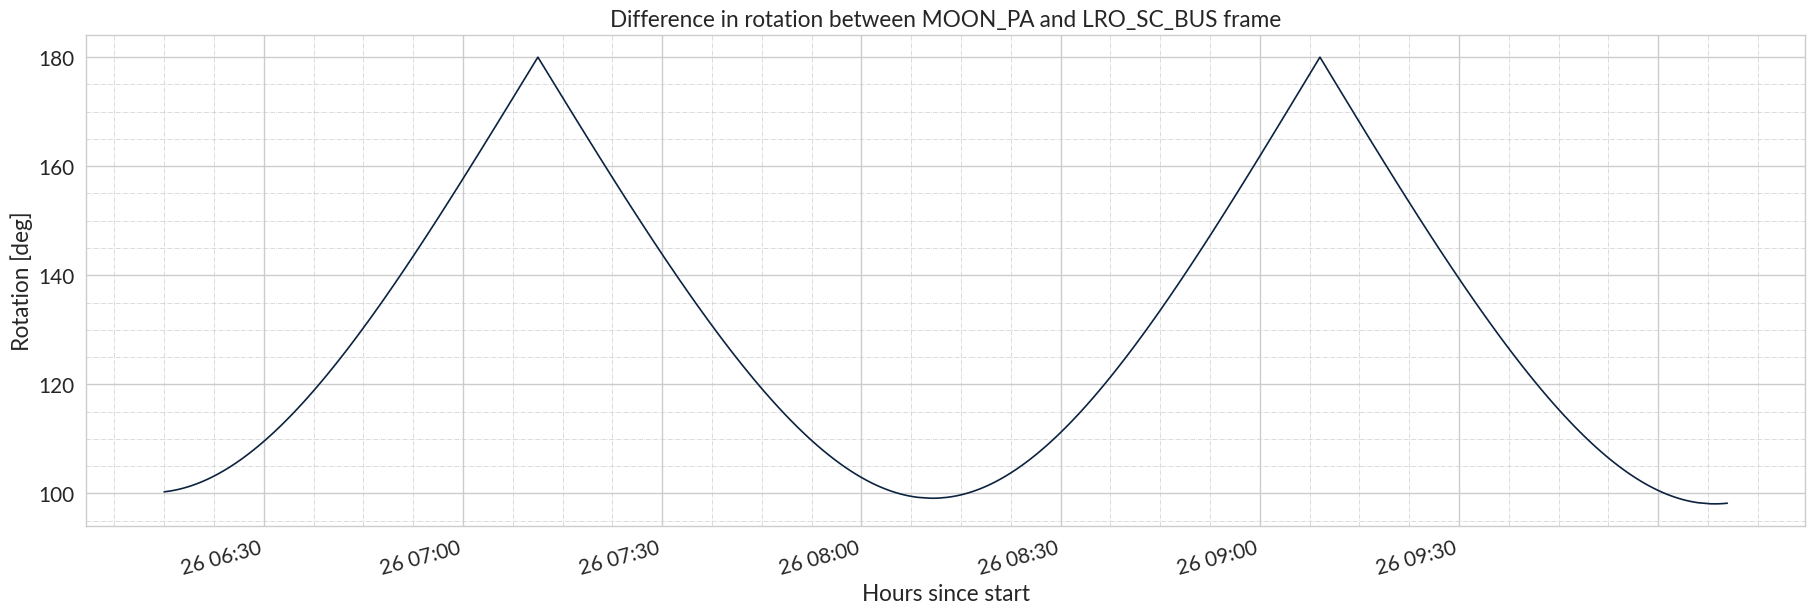

In [21]:
def plot_frame_difference(from_frame: str, to_frame: str):
    def quat_to_deg(q):
        ang_rad = 2 * np.arctan2(np.linalg.norm(q[1:]), q[0])
        return np.degrees(ang_rad)

    fig, ax = plt.subplots(figsize=(18, 6))

    # t_start = as_et("2010 SEP 11 01:00:00")
    # t_end = as_et("2010 OCT 21 00:00:00")
    t_start = as_et("2010 JUN 26 06:00:00")
    t_end = t_start + 2 * 113 * 60
    t = np.linspace(t_start, t_end, 10000)

    plt.plot(
        # (t - t_start) / (3600),
        pd.to_datetime([as_utc(tt) for tt in t]),
        np.vectorize(lambda tt: quat_to_deg(spice.m2q(spice.pxform(from_frame, to_frame, tt))))(t))
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

    plt.xlabel("Hours since start")
    plt.ylabel("Rotation [deg]")
    plt.title(f"Difference in rotation between {from_frame} and {to_frame} frame")

    format_plot()

plot_frame_difference("MOON_PA", "LRO_SC_BUS")
# plot_frame_difference("ECLIPJ2000", "LRO_SC_BUS")
# plot_frame_difference("IAU_EARTH", "LRO_SC_BUS")

# Mass

In [22]:
def load_mass_history():
    def parse_line(line):
        date = pd.to_datetime(line[56:73], format="%Y %j %H:%M:%S", utc=True)
        fuel_mass = float(line[104:111])
        return date, fuel_mass

    dry_mass = 1020.9
    history = []
    for f in Path("files/lro_sff").glob("*.txt"):
        line_start, line_stop, _, line_avg = f.open().readlines()[2:6]
        average_mass = float(line_avg[103:111])
        history.append(parse_line(line_start) + (average_mass,))
        history.append(parse_line(line_stop) + (average_mass,))
    
    history = pd.DataFrame(history, columns=["date", "fuel_mass", "average_mass"]).set_index("date").sort_index()
    history["mass"] = dry_mass + history["fuel_mass"]
    return history

mass_history = load_mass_history()

In [33]:
mass_history.iloc[-40:]

,fuel_mass,average_mass,mass
date,,,
2011-10-03 17:48:34+00:00,82.796,1102.340,1103.696
2011-10-03 17:49:50+00:00,80.136,1102.340,1101.036
2011-10-03 20:46:44+00:00,80.136,1099.620,1101.036
2011-10-03 20:48:03+00:00,77.360,1099.620,1098.260
2011-10-31 17:03:50+00:00,77.033,1096.365,1097.933
2011-10-31 17:05:17+00:00,73.958,1096.365,1094.858
2011-10-31 19:55:09+00:00,73.958,1092.430,1094.858
2011-10-31 19:57:25+00:00,69.157,1092.430,1090.057
2011-11-27 13:53:55+00:00,69.023,1088.965,1089.923


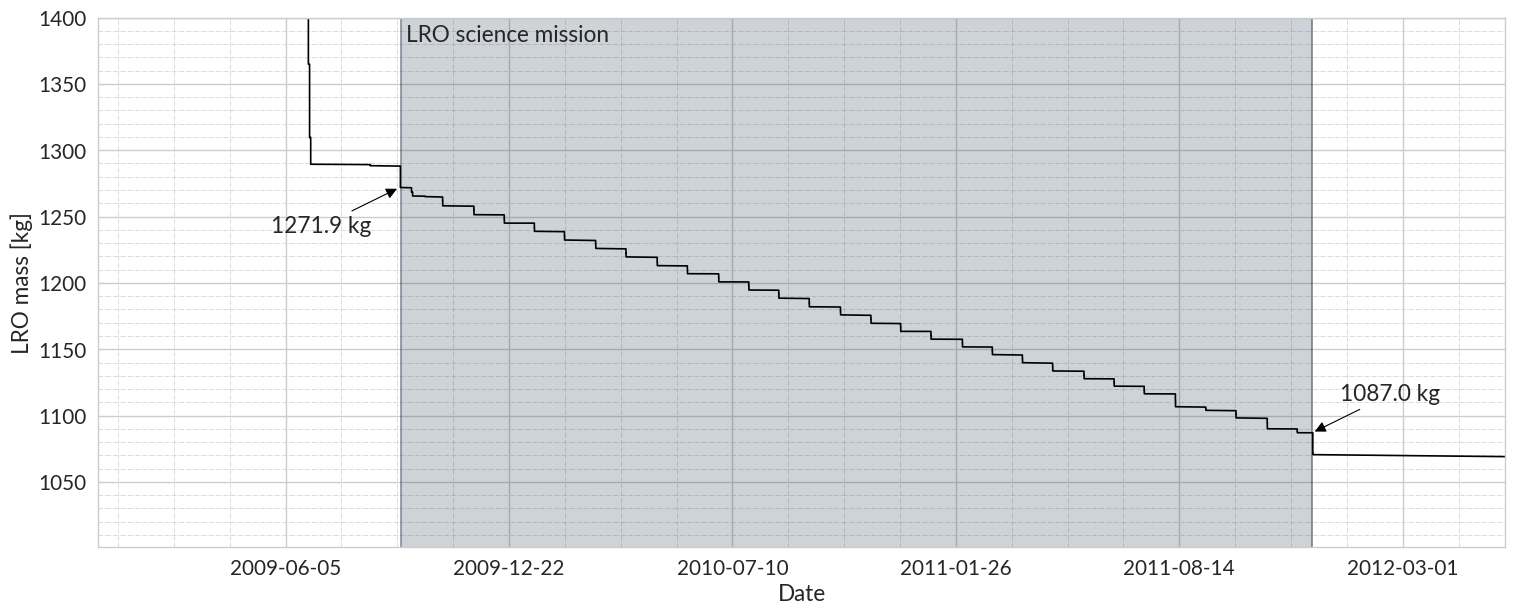

In [52]:
def plot_mass_history():
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.axvline(datetime(2009, 9, 16), alpha=0.5)  # actually September 15
    ax.axvline(datetime(2011, 12, 11), alpha=0.5)  # actually December 11
    ax.axvspan(datetime(2009, 9, 16), datetime(2011, 12, 11), alpha=0.2)

    ax.annotate("LRO science mission", (datetime(2009, 9, 15), 1400), xytext=(5, -5), textcoords="offset points", va="top")

    start_mass = get_closest_before(mass_history, datetime(2009, 9, 16, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{start_mass:.1f} kg",
        (datetime(2009, 9, 15), start_mass),
        xytext=(-20, -20),
        va="top",
        ha="right",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    end_mass = get_closest_after(mass_history, datetime(2011, 12, 10, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{end_mass:.1f} kg",
        (datetime(2011, 12, 11), end_mass),
        xytext=(20, 20),
        va="bottom",
        ha="left",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    # ax.scatter(mass_history.index, mass_history["mass"], marker=".", color="black")
    ax.plot(mass_history.index, mass_history["mass"], color="black")
    # ax.plot(mass_history.index, mass_history["average_mass"], color="black")

    ax.set_xlabel("Date")
    ax.set_ylabel("LRO mass [kg]")
    ax.set_xlim([ax.get_xlim()[0], datetime(2012, 6, 1)])
    ax.set_ylim([ax.get_ylim()[0], 1400])

    format_plot()

plot_mass_history()